In [1]:
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)

In [2]:
import matplotlib.pyplot as plt
from tensorflow import keras
from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA
import numpy as np
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from collections import Counter
import pandas as pd 
from sklearn.tree import plot_tree
import tensorflow as tf

from sklearn.ensemble import BaggingClassifier

In [3]:
#Raccourci load data 1
fraude = pd.read_table("/Volumes/KINGSTON/M2/Big data mining/Projet_BDM/dataproject.txt",sep=";",decimal=",")

fraude['FlAgImpAye'] = fraude['FlAgImpAye'].astype(str) 
fraude['CodeDecision'] = fraude['CodeDecision'].astype(str) 
fraude['IDAvisAutorisAtionCheque'] = fraude['IDAvisAutorisAtionCheque'].astype(str) 

#Variables actives originales
fraude_act = fraude.iloc[:,2:23]

#fraude2 = data avec dummy 
dummy = pd.get_dummies(fraude['CodeDecision'], prefix='Code' )
dummy

fraude2 = fraude.drop('CodeDecision',axis='columns')
fraude2 = pd.concat([fraude2,dummy],axis=1)

#Train exploitable 
fraude_train = fraude2.iloc[0:1967226]

#Test exploitable 
fraude_test = fraude2.iloc[1967226:len(fraude.index)]

#Train des variables actives exploitable 
fraude_train_act = fraude_train.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')

#Test des variables actives
fraude_test_act = fraude_test.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')

#Variables actives + cible pour les stats desc 
fraude_desc = pd.concat([fraude_train_act,fraude_train['FlAgImpAye']],axis=1)

In [4]:
fraude_train_v = fraude_train.iloc[0:1677541,:]
fraude_train_act_v = fraude_train_act.iloc[0:1677541,:]
fraude_valid = fraude_train.iloc[1677541:1967226,:]
fraude_train_v.FlAgImpAye.value_counts()

0    1673087
1       4454
Name: FlAgImpAye, dtype: int64

In [5]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

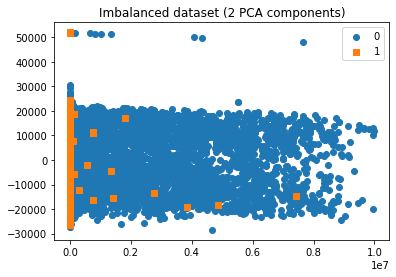

In [6]:
y=fraude_train_v['FlAgImpAye']
pca = PCA(n_components=2)
X = pca.fit_transform(fraude_train_act_v)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

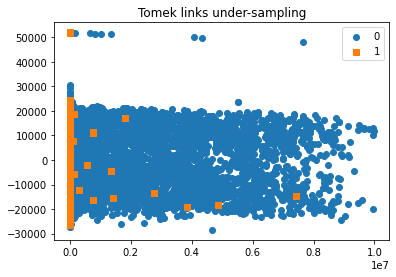

In [7]:
tl = TomekLinks(sampling_strategy="majority") #return_indices=True, ratio='majority'
X_tl, y_tl = tl.fit_sample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')




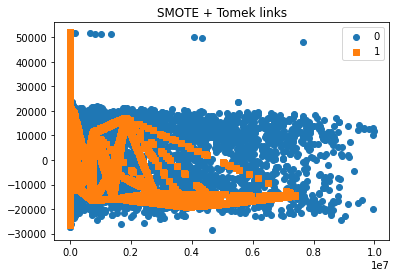

In [8]:
smt = SMOTETomek(n_jobs=-1)
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [9]:

#-----------------ARBRE-------------------------

ytrain_arbre_red = fraude_train_v.iloc[tl.sample_indices_,:]
ytrain_arbre_red= ytrain_arbre_red['FlAgImpAye']
xtrain_arbre_red = fraude_train_act_v.iloc[tl.sample_indices_,:]
train_arbre_red = pd.concat([xtrain_arbre_red,ytrain_arbre_red],axis=1)

#ytest_arbre_red = ytest_keras
#xtest_arbre_red = xtest_keras
#test_arbre_red = pd.concat([xtest_arbre_red,fraude_test['FlAgImpAye']],axis=1)

yvalid_arbre = fraude_valid['FlAgImpAye']
xvalid_arbre = fraude_valid.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')
valid_arbre = fraude_valid



In [10]:
def calcul_F(mat):
    
    TP= mat[0,0]
    FN= mat[0,1]
    FP= mat[1,0]
    #F= 2TP / 2T P + F N + F P
    F= 2*TP/(2*TP+FN+FP)
    return(F)

In [11]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler()#sampling_strategy='majority'

In [12]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(fraude_train_act_v, fraude_train_v['FlAgImpAye'])

In [13]:
#ytrain_arbre_red = fraude_train_v.iloc[tl.sample_indices_,:]
#ytrain_arbre_red= ytrain_arbre_red['FlAgImpAye']
#xtrain_arbre_red = fraude_train_act_v.iloc[tl.sample_indices_,:]
#train_arbre_red = pd.concat([xtrain_arbre_red,ytrain_arbre_red],axis=1)

#yvalid_arbre = fraude_valid['FlAgImpAye']
#xvalid_arbre = fraude_valid.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')
#valid_arbre = fraude_valid

ytrain_nn_tl = np.array(ytrain_arbre_red, dtype="uint8")
xtrain_nn_tl = xtrain_arbre_red
yvalid_nn = np.array(yvalid_arbre, dtype="uint8")
xvalid_nn = xvalid_arbre
valid_nn = valid_arbre



In [14]:
counts = np.bincount(ytrain_nn_tl)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(ytrain_nn_tl)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 4454 (0.27% of total)


In [15]:
#Normalisation des donénes 


mean = np.mean(xtrain_nn_tl, axis=0)
xtrain_nn_tl -= mean
xvalid_nn -= mean
std = np.std(xtrain_nn_tl, axis=0)
xtrain_nn_tl /= std
xvalid_nn /= std

In [16]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier( alpha=1e-5,
                    hidden_layer_sizes=(15, 5), random_state=1,activation='tanh')





In [17]:
clf.fit(xtrain_nn_tl, ytrain_nn_tl)

MLPClassifier(activation='tanh', alpha=1e-05, hidden_layer_sizes=(15, 5),
              random_state=1)

In [18]:
clfpred=clf.predict(xvalid_nn)

In [19]:
print(metrics.confusion_matrix(yvalid_nn,clfpred,labels=[1, 0]))

[[    26    922]
 [     7 288730]]


In [20]:
print(metrics.roc_auc_score(yvalid_nn,clfpred))

0.5137009584109137


In [21]:
calcul_F(metrics.confusion_matrix(yvalid_nn,clfpred,labels=[1, 0]))

0.053007135575942915

--------------------------------- RANDOM UNDER SAMPLING --------------------------------------

In [23]:
ytrain_nn_tl2 = np.array(y_under, dtype="uint8")
xtrain_nn_tl2 = X_under

yvalid_nn2 = np.array(yvalid_arbre, dtype="uint8")
xvalid_nn2 = xvalid_arbre
valid_nn2 = valid_arbre





In [24]:
#Normalisation des donénes 


mean2 = np.mean(xtrain_nn_tl2, axis=0)
xtrain_nn_tl2 -= mean2
xvalid_nn2 -= mean2
std2 = np.std(xtrain_nn_tl2, axis=0)
xtrain_nn_tl2 /= std2
xvalid_nn2 /= std2

In [68]:
clf2 = MLPClassifier( alpha=1e-5,
                    hidden_layer_sizes=(15, 5), 
                     random_state=1,
                     activation='tanh',
                     max_iter=500,
                    learning_rate='adaptive')


#augmentation de maxiter car pas convegé sinon 



In [69]:
clf2.fit(xtrain_nn_tl2, ytrain_nn_tl2)

MLPClassifier(activation='tanh', alpha=1e-05, hidden_layer_sizes=(15, 5),
              learning_rate='adaptive', max_iter=500, random_state=1)

In [70]:
clfpred2=clf2.predict(xvalid_nn2)

In [71]:
print(metrics.confusion_matrix(yvalid_nn2,clfpred2,labels=[1, 0]))

[[   761    187]
 [184062 104675]]


In [72]:
print(metrics.roc_auc_score(yvalid_nn2,clfpred2))

0.5826348800564847


In [58]:
calcul_F(metrics.confusion_matrix(yvalid_nn2,clfpred2,labels=[1, 0]))

0.008192882635072212

In [59]:
bc = BaggingClassifier(base_estimator=clf2, n_estimators=300, n_jobs=-1) #
# Fit 'bc' to the training set
bc.fit(xtrain_nn_tl2, ytrain_nn_tl2)

BaggingClassifier(base_estimator=MLPClassifier(activation='tanh', alpha=1e-05,
                                               hidden_layer_sizes=(15, 5),
                                               max_iter=500, random_state=1),
                  n_estimators=300, n_jobs=-1)

In [60]:
bcpred=bc.predict(xvalid_nn)

In [62]:
print(metrics.confusion_matrix(yvalid_nn2,bcpred,labels=[1, 0]))

[[   943      5]
 [288487    250]]


In [63]:
calcul_F(metrics.confusion_matrix(yvalid_nn2,bcpred,labels=[1, 0]))

0.0064949824022481045